# NeuroGym

NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using standard supervised learning techniques (with Keras), and plot the results.

### Installation

In [1]:
%tensorflow_version 1.x
# Install gym
! pip install gym
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 7718 (delta 249), reused 243 (delta 160), pack-reused 7368
Receiving objects: 100% (7718/7718), 7.57 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (5664/5664), done.
/content/neurogym
Obtaining file:///content/neurogym
  Running setup.py develop for neurogym


### Example

In [2]:
import warnings

import numpy as np
import neurogym as ngym

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Input

warnings.filterwarnings('ignore')
warnings.filterwarnings('default')

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 40

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)
env = dataset.env
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n

# Model 
num_h = 64
# from https://www.tensorflow.org/guide/keras/rnn
xin = Input(batch_shape=(None, None, obs_size), dtype='float32')
seq = LSTM(num_h, return_sequences=True)(xin)
mlp = TimeDistributed(Dense(act_size, activation='softmax'))(seq)
model = Model(inputs=xin, outputs=mlp)
model.summary()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train network
steps_per_epoch = 2000
data_generator = (dataset() for i in range(steps_per_epoch))
history = model.fit(data_generator, steps_per_epoch=steps_per_epoch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/content/neurogym/neurogym/core.py:253: UserWarning: Warning: Time for period fixation 100.000000  lasts only one timestep. Agents will not have time to respond (e.g. make a choice) on time.
  ' time to respond (e.g. make a choice) on time.')
/content/neurogym/neurogym/core.py:253: UserWarning: Warning: Time for period decision 100.000000  lasts only one timestep. Agents will not have time to respond (e.g. make a choice) on time.
  ' time to respond (e.g. make a choice) on time.')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          17408     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 3)           195       
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2000/2000 [==============================] - 116s 58ms/step - loss: 0.0398 - acc: 0.9934


In [5]:
# TODO: Make this into a function in neurogym
perf = 0
num_trial = 200
for i in range(num_trial):
    env.new_trial()
    obs, gt = env.obs, env.gt
    obs = obs[np.newaxis]

    action_pred = model.predict(obs)
    action_pred = np.argmax(action_pred, axis=-1)
    perf += gt[-1] == action_pred[0, -1]

perf /= num_trial
print(perf)

/content/neurogym/neurogym/core.py:253: UserWarning: Warning: Time for period fixation 100.000000  lasts only one timestep. Agents will not have time to respond (e.g. make a choice) on time.
  ' time to respond (e.g. make a choice) on time.')
/content/neurogym/neurogym/core.py:253: UserWarning: Warning: Time for period decision 100.000000  lasts only one timestep. Agents will not have time to respond (e.g. make a choice) on time.
  ' time to respond (e.g. make a choice) on time.')


0.755


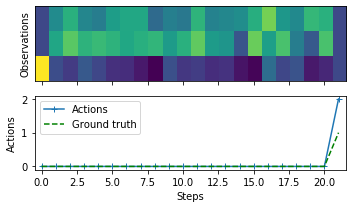

In [6]:
_ = ngym.utils.plotting.fig_(obs[0], action_pred[0], gt)